kernel rapids

# Figure 3

In [306]:
import scanpy as sc
import rapids_singlecell as rsc
import cupy as cp
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import random
from matplotlib.colors import LinearSegmentedColormap
from pandas.api.types import CategoricalDtype
from scipy.cluster.hierarchy import fcluster
import json
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score

In [22]:
# Keep text editable
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'

In [23]:
from cuml.manifold import TSNE

In [24]:
import rmm
from rmm.allocators.cupy import rmm_cupy_allocator

rmm.reinitialize(
    managed_memory=False,  # Allows oversubscription
    pool_allocator=False,  # default is False
    devices=0,  # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm_cupy_allocator)

In [25]:
data_path = '../Data/xenium_ovarian_cancer_full.h5ad'
out_dir = 'Fig_3/'

In [26]:
data = sc.read_h5ad(data_path)

In [62]:
data

AnnData object with n_obs × n_vars = 406875 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'cell_labels', 'cell_type', 'is_tumor_cell_type', '10X_cell_type', 'transcriptome_passed_QC', 'is_ovary_cell_type', 'is_in_vitmae_test_set', 'SCimilarity_transcriptome_cell_type', 'SCimilarity_transcriptome_min_dist', 'SCimilarity_image_cell_type', 'SCimilarity_image_min_dist', 'Prediction_MSE'
    var: 'gene_ids', 'feature_types', 'genome', 'gene_passed_QC'
    uns: 'spatialdata_attrs'
    obsm: 'X_SCimilarity_image_embeds', 'X_SCimilarity_transcriptome_embeds', 'X_vitmae_finetuned_img_features', 'X_vitmae_finetuned_img_features_minmax', 'X_vitmae_imagenet_img_features', 'spatial'

## Fig 3b SCimilarity Image Embeddings

In [310]:
test_data = data[data.obs['is_in_vitmae_test_set'] == True].copy()
test_data = test_data[test_data.obs['is_tumor_cell_type'] == False].copy()

In [311]:
r2_single = r2_score(
    test_data.obsm['X_SCimilarity_transcriptome_embeds'].flatten(),
    test_data.obsm['X_SCimilarity_image_embeds'].flatten()
)
print("Overall R²:", r2_single)

Overall R²: 0.6489838361740112


In [307]:
plot_data = ad.AnnData(
    X=data.obsm['X_SCimilarity_image_embeds'],
    obs=data.obs
)

In [308]:
plot_data = plot_data[plot_data.obs['is_in_vitmae_test_set'] == True]
plot_data = plot_data[plot_data.obs['is_tumor_cell_type'] == False].copy()

In [282]:
plot_data.obs

,cell_id,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,...,is_tumor_cell_type,10X_cell_type,transcriptome_passed_QC,is_ovary_cell_type,is_in_vitmae_test_set,SCimilarity_transcriptome_cell_type,SCimilarity_transcriptome_min_dist,SCimilarity_image_cell_type,SCimilarity_image_min_dist,Prediction_MSE
18,aaacgebm-1,292,0,0,0,0,13,305,59.696565,43.033908,...,False,Ciliated Epithelial Cells,True,False,True,leukocyte,0.319058,epithelial cell,0.243474,0.005709
102,aabbanlb-1,586,0,0,0,0,55,641,123.908754,64.076721,...,False,Macrophages,True,False,True,macrophage,0.092365,macrophage,0.085596,0.000369
377,aadmmoid-1,194,0,0,0,0,7,201,68.276252,41.001876,...,False,Macrophages,False,False,True,dendritic cell,0.088871,macrophage,0.072303,0.001416
454,aaeibddp-1,341,0,0,0,0,21,362,87.557972,24.881095,...,False,Macrophages,True,False,True,macrophage,0.099870,macrophage,0.080263,0.000689
1153,aakjlnmm-1,245,0,0,0,0,35,280,79.745940,62.451096,...,False,Ciliated Epithelial Cells,True,False,True,leukocyte,0.151162,epithelial cell,0.189888,0.005611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406860,oiglcicd-1,261,0,0,0,0,23,284,247.998134,52.471564,...,False,Stromal Associated Fibroblasts,True,False,True,fibroblast,0.048105,fibroblast,0.070764,0.000849
406871,oigmleij-1,4,0,0,0,0,3,7,5.599375,5.599375,...,False,Stromal Associated Fibroblasts,False,False,True,fibroblast,0.098129,leukocyte,0.235618,0.008389
406917,oihdcdhg-1,99,0,0,0,0,18,117,56.761408,45.788439,...,False,Stromal Associated Fibroblasts,False,False,True,myofibroblast cell,0.193410,fibroblast,0.077807,0.004561
407003,oiiagpgm-1,19,0,0,0,0,5,24,16.707813,12.553438,...,False,Smooth Muscle Cells,False,False,True,fibroblast,0.150620,fibroblast,0.130238,0.003787


In [283]:
rsc.get.anndata_to_GPU(plot_data)

In [284]:
rsc.pp.scale(plot_data)

In [285]:
rsc.tl.tsne(plot_data)

[2025-08-29 14:05:14.199] [CUML] [info] Unused keyword parameter: random_state during cuML estimator initialization


In [286]:
plot_data.obs['SCimilarity_image_cell_type'].value_counts()

SCimilarity_image_cell_type
smooth muscle cell    2850
fibroblast            1470
endothelial cell      1048
macrophage             908
myofibroblast cell     715
epithelial cell        689
leukocyte              376
dendritic cell          11
monocyte                 3
Name: count, dtype: int64

In [288]:
color_palette_path = 'Fig_3/color_palette_image.pkl'
palette = pd.read_pickle(color_palette_path)

In [292]:
palette

{'leukocyte': '#2f559a',
 'fibroblast': '#519bbc',
 'endothelial cell': '#78b6a3',
 'epithelial cell': '#b7c95a',
 'macrophage': '#eeab1a',
 'dendritic cell': '#e77b21',
 'myofibroblast cell': '#da5826',
 'monocyte': '#c63e28',
 'smooth muscle cell': '#b3262a'}

In [299]:
np.save(f'{out_dir}tsne_coords.npy', plot_data.obsm['X_tsne'])

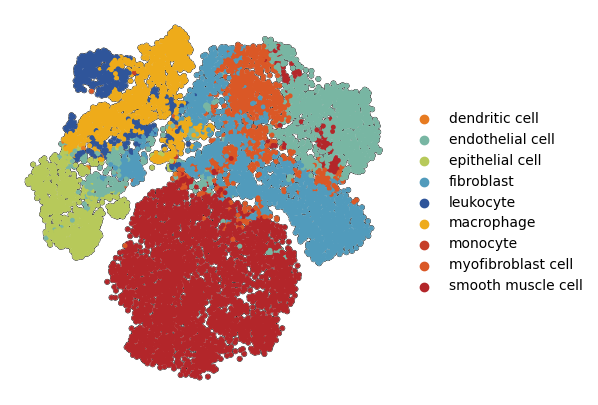

In [291]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.tsne(
    plot_data,
    color = 'SCimilarity_image_cell_type',
    palette=palette,
    ax = ax,
    s = 50,
    alpha = 1,
    add_outline = True,
    outline_width = (0.1,0),
    frameon=False,
    legend_loc=None,
    title='',
    na_color='white',
)
ax.set_aspect('equal')
fig.tight_layout()
fig.savefig(f'{out_dir}Fig_3c.png', dpi=600, bbox_inches='tight',)

In [303]:
rsc.pp.neighbors(plot_data, use_rep='X')

In [304]:
rsc.tl.umap(plot_data)

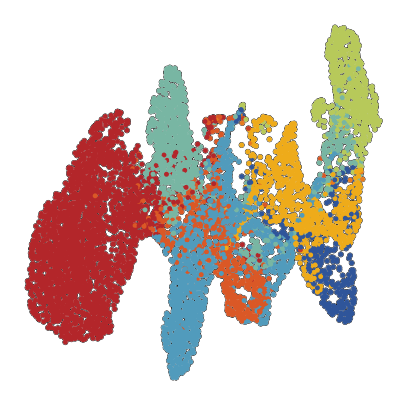

In [305]:
fig, ax = plt.subplots(figsize=(5, 5))

sc.pl.umap(
    plot_data,
    color = 'SCimilarity_image_cell_type',
    palette=palette,
    ax = ax,
    s = 50,
    alpha = 1,
    add_outline = True,
    outline_width = (0.1,0),
    frameon=False,
    legend_loc=None,
    title='',
    na_color='white',
)
ax.set_aspect('equal')
fig.tight_layout()

In [189]:
# For Fig 3f
pd.DataFrame({
    'SCimilarity_image_cell_type': plot_data.obs['SCimilarity_image_cell_type'].unique().tolist(),
    'color': plot_data.uns['SCimilarity_image_cell_type_colors'],
}).to_csv(f'{out_dir}SCimilarity_image_cell_type_color_assignment.csv')

## Fig 3c Prediction Error by Cell Type

In [213]:
predicted_scim = data.obsm['X_SCimilarity_image_embeds']
original_scim = data.obsm['X_SCimilarity_transcriptome_embeds']
prediction_mse = np.mean((predicted_scim - original_scim) ** 2, axis=1)

In [214]:
data.obs['Prediction_MSE'] = prediction_mse

In [215]:
plot_data = data.obs[data.obs['is_in_vitmae_test_set'] == True].copy()

In [216]:
plot_data = plot_data[plot_data['is_tumor_cell_type'] == False]

In [273]:
color_palette_path = 'Fig_3/color_palette_10X_celltype.pkl'
palette = pd.read_pickle(color_palette_path)

In [219]:
# For Fig 3f
pd.DataFrame({
    '10X_cell_type': order,
    'color': palette,
}).to_csv(f'{out_dir}10X_cell_type_color_assignment.csv')

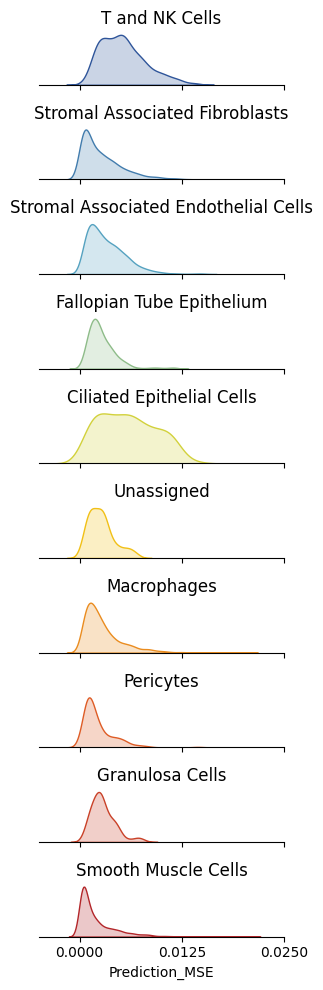

In [279]:
plot_data["10X_cell_type"] = pd.Categorical(plot_data["10X_cell_type"], categories=palette.keys(), ordered=True)
plot_data["10X_cell_type"] = plot_data["10X_cell_type"].cat.remove_unused_categories()

groups = plot_data.groupby("10X_cell_type", observed=False)
fig, axes = plt.subplots(len(groups), 1, figsize=(3, 1*len(groups)), sharex=True)

if len(groups) == 1:
    axes = [axes]

for ax, (name, group) in zip(axes, groups):
    color = palette.get(name, "#5aadc5")
    sns.kdeplot(data=group, x="Prediction_MSE", ax=ax, color=color, fill=True)
    ax.set_title(name)
    
    xlim = [-0.005,0.025]
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_xticks([0, 0.0125, 0.025])
    # ax.spines["bottom"].set_bounds(xlim[0], xlim[-1])
    # ax.tick_params(axis="x", direction="out")
    # ax.margins(x=0)
    
    ax.yaxis.set_visible(False)
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.spines["bottom"].set_visible(True)

plt.tight_layout()
plt.savefig(f'{out_dir}Fig_3d.pdf')